In [1]:
import xarray as xr
import numpy as np
import xcdat as xc
import xskillscore as xscore
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from scipy.stats import linregress
from scipy.stats import f
from scipy import stats
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.regression as regression
import statsmodels.formula.api as smf

In [14]:
def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = data.bounds.add_bounds("T")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

def global_plot(data, lon, lat, cmap, pvalues=None, right_title="", left_title="", levels=np.arange(-4, 4.1, .1)):
    # plot map of global data with central longitude 180
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
    img = ax1.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        extend="both",
        levels=levels,
    )
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    
    # Draw triangular region
    lat_min, lat_max = -40, 0
    lon_min, lon_max = -180, -70
    ax1.plot(
        [lon_min, lon_max, lon_max, lon_min], 
        [lat_max, lat_max, lat_min, lat_max], 
        color="black", linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )


    # Add Stippling
    if pvalues is not None:
        ax1.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
        
    ax1.coastlines()
    ax1.set_global()
    ax1.set_title(left_title, loc="left", fontweight="bold")
    ax1.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -45, 45
    ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    # Add a horizontal colorbar
    cbar = plt.colorbar(img, orientation='horizontal')

def get_region(name, flux): 
    # flux = remove_land_full(ds=flux[name], var=name)
    flux = fix_coords(flux.rename(name).to_dataset())

    flux_west = flux.sel(lat=slice(-5, 5), lon=slice(110, 165)).spatial.average(name)[name]
    flux_east = flux.sel(lat=slice(-5, 5), lon=slice(-135, -80)).spatial.average(name)[name]
    flux_WE = flux_west - flux_east

    flux_EPSA = flux.sel(lat=slice(-40, -5), lon=slice(-95, -70)).spatial.average(name)[name]

    flux_SO = flux.sel(lat=slice(-70, -50), lon=slice(-180, -75)).spatial.average(name)[name]

    flux_E = flux.sel(lat=slice(-5, 5), lon=slice(-135, -80)).spatial.average(name)[name]

    flux_EPT = get_triangle(flux[name])
    flux_EPT = fix_coords(flux_EPT.rename(name).to_dataset()).spatial.average(name)[name]

    return {"WE": flux_WE, "EPSA": flux_EPSA, "SO": flux_SO, "EP": flux_E, "EPT": flux_EPT}
    # return {"WE": flux_WE, "EPSA": flux_EPSA, "SO": flux_SO, "EP": flux_E}



def get_triangle(tos, latmin: float = -38.75, latmax: float = -1.25, lonmin: float = -178.75, lonmax: float = -71.25, RES: float = 2.5):
    DY = latmax - latmin
    DX = lonmax - lonmin 
    dx = RES*round(DX/DY)
    dy = RES

    # print(f"For each latitude step of {dy} degrees, longitude step is {dx}")

    latcoords = np.arange(latmax, latmin-dy, -dy)
    loncoords = np.arange(lonmin, lonmax+dx, dx)
    lonraw = np.arange(lonmin, lonmax+dx, RES)

    ctos = tos.sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax)).copy()
    ctos = ctos.transpose("lat", "lon", "time").load()
    nlat, nlon, ntime = ctos.shape

    for i, clon in enumerate(lonraw):
        j = np.where(clon == loncoords)[0]

        if i == nlon: break

        # print("j prior: ", j)
        if len(j) == 0: 
            j = jold
        else: 
            j = j[0]
             
        # print("j: ", j)
        nlats = int(len(latcoords) - j) # nlats below diag
        # print("nlats: ", nlats)
        ctos[:nlats,i,:] = np.full((nlats,ntime), np.nan) 
        
        jold = j
    
    return ctos


def remove_land_full(ds, var="skt"):
    ds = ds.rename(var).to_dataset()
    ds = xc.swap_lon_axis(ds, to=(-180, 180))
    from global_land_mask import globe
    # Set land to NaN
    lon_grid,lat_grid = np.meshgrid(ds.lon, ds.lat)
    globe_land_mask = globe.is_land(lat_grid,lon_grid)
    globe_land_mask_nd = np.tile(globe_land_mask,(ds[var].shape[0],ds[var].shape[1], 1,1))
    ds_no_land = xr.where(globe_land_mask_nd==True,np.nan,ds[var]) 
    return ds_no_land

    


# Granger Causality Core Functionality

In [3]:
def make_stationary(ts: xr.DataArray, sanity_check: bool = False):
    """ Make time series stationary by removing mean, dividing by variance and linear detrending

    Args:
        ts (xr.DataArray): 1D time series
    """

    tss = (ts - ts.mean())/ts.std()
    time = np.arange(len(tss))
    reg = linregress(time, tss)
    tsd = tss - (reg.slope*time + reg.intercept)

    if sanity_check:
        # Log the original and stationary mean and variance
        print("Original Variance: ", ts.std().values, "and Original Mean: ", ts.mean().values)
        print("Stationary Variance: ", tsd.std().values, "and Stationary Mean: ", tsd.mean().values)
        # Plot the original and stationary time series
        plt.plot(ts.time, ts, label="original")
        plt.plot(tsd.time, tsd, label="detrended")
        plt.legend(); plt.grid(); plt.xlabel("time"); plt.ylabel("Variable")
    
    return tsd

In [78]:
def multivariable_regression(X: xr.DataArray, Y: xr.DataArray, verbose: bool = False):
    # Perform multivariable ordinaty least squares regression
    # model = linear_model.LinearRegression()
    # model.fit(X, Y)

    model = regression.linear_model.OLS(Y, X).fit()

    if verbose:
        print(model.summary())
    
    return model

def create_dataset(ds1: xr.DataArray, nlag: int = 10, include_zero_lag: bool = False):

    nsamples = ds1.shape[0] - nlag 

    X = np.full((nsamples, nlag), np.nan)
    Y = np.full((nsamples), np.nan)

    for i in range(nsamples):
        if not include_zero_lag:
            X[i,:] = ds1[i+1:i+nlag+1]
        else: 
            X[i,:] = ds1[i:i+nlag]
        Y[i] = ds1[i]

    
    return X, Y

def get_AIC_lag(x):
    return 10
    # NLAG = 50
    # print(Y1.shape[0] - NLAG - 1)
    # if NLAG*2 > (Y1.shape[0] - NLAG - 1): 
    #     NLAG = int(np.floor((Y1.shape[0] - NLAG - 1)/2))

def granger_causality(Xr: np.ndarray, X: np.ndarray, Y:np.ndarray, unrestricted_model, restricted_model, nlag: int = 10, verbose: bool = False):
    """_summary_

    Args:
        Y1 (np.ndarray): _description_
        Y2 (np.ndarray): _description_
        unrestricted_model (_type_): _description_
        restricted_model (_type_): _description_
    """
    # Get Predictions
    Yp_restricted = restricted_model.predict(Xr) # Equivalent to np.matmul(X1, restricted_model.coef_) + restricted_model.intercept_
    Yp_unrestricted = unrestricted_model.predict(X) # Equivalent to np.matmul(X2, unrestricted_model.coef_) + unrestricted_model.intercept_

    # Get Residuals
    err_y1 = Y - Yp_restricted
    err_y2 = Y - Yp_unrestricted
    
    # F-test on residuals
    F = np.var(err_y1)/np.var(err_y2) # Ratio of variances
    df1, df2 = len(err_y1) - 1, len(err_y2) - 1 # Number of samples - 1
    p_value = f.sf(F, df1, df2) # Survival function (1 - cdf) at F
    p_value = 0

    # Signifigance of regression coefficients
    ALPHA = 0.05
    sig_reg_coeffs = unrestricted_model.pvalues[nlag+1:] # +1 to exlude include intercept 

    # Test Granger Causality
    if np.any(sig_reg_coeffs <= ALPHA) and p_value < ALPHA:
        causality = True
        magnitude = np.sum(unrestricted_model.params[nlag+1:][sig_reg_coeffs <= ALPHA]) # Get the regression coefficients that are significant and sum them
        if verbose: print(f"Reject Null Hypothesis: Granger Causality DOES exist: {magnitude} with nlag={nlag}, F-test p={p_value}, p-values of regression coefficients: {sig_reg_coeffs}")
    else: 
        magnitude = np.nan
        causality = False
        if verbose: print(f"Fail to Reject Null Hypothesis: Granger Causality DOES NOT exist: F-test p={p_value}, p-values of regression coefficients: {sig_reg_coeffs}")

    return Yp_restricted, Yp_unrestricted, magnitude, causality

In [134]:
def Granger_Pipeline(Y1, Y2, sanity_check: bool = False, include_zero_lag: bool = False, verbose: bool = True):
    Y1 = make_stationary(Y1, sanity_check=sanity_check)
    Y2 = make_stationary(Y2, sanity_check=sanity_check)

    MAXLAG = int(25)
    Y2_pred_Y1, Y1_pred_Y2 = {}, {}
    aic_Y2_pred_Y1, aic_Y1_pred_Y2 = np.inf, np.inf
    for NLAG in range(1, MAXLAG):
        # NLAG = 60 # 5 year lag for monthly data
        NLAG = 5 # 5 year lag for annual data
        # NLAG = 5 # 5 year lag for annual data
        ##### Does Y2 Granger Cause Y1? #####
        # Restricted Model
        X1_ds, Y1_ds = create_dataset(ds1=Y1, nlag=NLAG, include_zero_lag=include_zero_lag)
        if include_zero_lag: 
            X1_ds = X1_ds[:,1:]
        X1_ds = sm.add_constant(X1_ds)
        restricted_model = multivariable_regression(X1_ds, Y1_ds, verbose=verbose)

        # Unrestricted Model
        X2_ds, Y2_ds = create_dataset(ds1=Y2, nlag=NLAG, include_zero_lag=include_zero_lag)
        if include_zero_lag: 
            X2_ds = X2_ds[:,1:]
        X_ds = np.concatenate([X1_ds, X2_ds], axis=1) 
        unrestricted_model = multivariable_regression(X=X_ds, Y=Y1_ds, verbose=verbose) 

        if aic_Y2_pred_Y1 > unrestricted_model.aic:
            aic_Y2_pred_Y1 = unrestricted_model.aic
            if verbose: print("New best model found: ", unrestricted_model.aic)
            Y2_pred_Y1["restricted_model"] = restricted_model
            Y2_pred_Y1["unrestricted_model"] = unrestricted_model
            Y2_pred_Y1["nlag"] = NLAG
            Y2_pred_Y1["Xr"] = X1_ds
            Y2_pred_Y1["X"] = X_ds
            Y2_pred_Y1["Y"] = Y1_ds

        ##### Does Y1 Granger Cause Y2? #####
        # Restricted Model
        X2_ds, Y2_ds = create_dataset(ds1=Y2, nlag=NLAG, include_zero_lag=include_zero_lag)
        X2_ds = sm.add_constant(X2_ds)
        restricted_model = multivariable_regression(X2_ds, Y2_ds, verbose=verbose)
        # Unrestricted Model
        X1_ds, Y1_ds = create_dataset(ds1=Y1, nlag=NLAG, include_zero_lag=include_zero_lag)
        X_ds = np.concatenate([X2_ds, X1_ds], axis=1) 
        unrestricted_model = multivariable_regression(X=X_ds, Y=Y2_ds, verbose=verbose) 

        if aic_Y1_pred_Y2 > unrestricted_model.aic:
            aic_Y1_pred_Y2 = unrestricted_model.aic
            if verbose: print("New best model found: ", unrestricted_model.aic)
            Y1_pred_Y2["restricted_model"] = restricted_model
            Y1_pred_Y2["unrestricted_model"] = unrestricted_model
            Y1_pred_Y2["nlag"] = NLAG
            Y1_pred_Y2["Xr"] = X2_ds
            Y1_pred_Y2["X"] = X_ds
            Y1_pred_Y2["Y"] = Y2_ds

        break

    Y1p_restricted, Y1p_unrestricted, magnitudeY1, causalityY1 = granger_causality(
        Xr=Y2_pred_Y1["Xr"],
        X=Y2_pred_Y1["X"],
        Y=Y2_pred_Y1["Y"],
        unrestricted_model=Y2_pred_Y1["unrestricted_model"], 
        restricted_model=Y2_pred_Y1["restricted_model"], 
        nlag=Y2_pred_Y1["nlag"],
        verbose=verbose
    )

    Y2p_restricted, Y2p_unrestricted, magnitudeY2, causalityY2 = granger_causality(
        Xr=Y1_pred_Y2["Xr"],
        X=Y1_pred_Y2["X"],
        Y=Y1_pred_Y2["Y"],
        unrestricted_model=Y1_pred_Y2["unrestricted_model"], 
        restricted_model=Y1_pred_Y2["restricted_model"], 
        nlag=Y1_pred_Y2["nlag"],
        verbose=verbose
    )
    

    
    return causalityY1, causalityY2, magnitudeY1, magnitudeY2
    

In [16]:
# swcf_epsa = xr.open_dataset("data/piControl/swcf_east_sa_cmip6.nc")
# SST_T_EPT_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacificTriangle_trend.nc")

SST_T_EPSA_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacificSA_trend.nc")
TOS_T_CMIP6 = xr.open_dataarray("data/piControl/rolling_gradient_TOS_CMIP6.nc").rename("TOS").to_dataset()
TOS_T_CMIP6 = fix_coords(TOS_T_CMIP6).sel(lat=slice(-30, 30), lon=slice(-180, 180), model="CanESM5-1")["TOS"]
SST_T_EPSA_CMIP6

<xarray.DataArray (model: 54, time: 120)>
[6480 values with dtype=float64]
Coordinates:
  * model    (model) object 'E3SM-1-1' 'E3SM-1-0' ... 'E3SM-2-0' 'CanESM5-1'
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 112 113 114 115 116 117 118 119

In [16]:
tos = xr.open_dataset("data/piControl/tos_anoms_mon_1850-2100_CMIP6_piControl.nc").sel(model="CanESM5-1")
tos_regions = get_region(flux=tos["tos"].drop("model"), name="tos")
tos_EPSA = tos_regions["EPSA"]
tos_EPT = tos_regions["EPT"]
tos_SO = tos_regions["SO"]
tos_SO
# tos = fix_coords(tos.drop("model"))
# tos = tos.sel(lat=slice(-45, 45), lon=slice(-180, 180))["tos"]
# tos

<xarray.DataArray 'tos' (time: 1800)>
array([ 0.27456345,  0.31586735,  0.32777553, ..., -0.07022401,
        0.13242241,  0.28246216])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 1999-12-01
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      Sea Surface Temperature
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    units:          degC
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello
    history:        2019-10-28T20:27:47Z altered by CMOR: replaced missing va...
    regrid_method:  bilinear
    operation:      temporal_avg
    mode:           departures
    freq:           month
    weighted:       True

In [23]:
def main(X, Y, save_name_Y1: str = "", save_name_Y2: str = ""):
    ntime, nlat, nlon = Y.shape

    magY1, magY2 = np.full((nlat, nlon), np.nan), np.full((nlat, nlon), np.nan)
    for model in ["CanESM5-1"]:
        for i, lat in enumerate(Y.lat.values):
            print("Current lat: ", lat)
            for j, lon in enumerate(Y.lon.values):
                try:
                    # Remove Nans
                    cY = Y.sel(lat=lat, lon=lon).dropna("time")
                    cX = X.sel(time=cY.time)
                    # Run Granger Causality Pipeline
                    causalityY1, causalityY2, magnitudeY1, magnitudeY2 = Granger_Pipeline(Y1=cX, Y2=cY.values, include_zero_lag=False, verbose=False)
                    magY1[i, j] = magnitudeY1
                    magY2[i, j] = magnitudeY2
                    # print("Success at: ", lat, lon)
                except Exception as e:
                    print("Failed at: ", lat, lon, e)
                    pass

    magY1 = xr.DataArray(magY1, dims=["lat", "lon"], coords={"lat": Y.lat, "lon": Y.lon})
    magY2 = xr.DataArray(magY2, dims=["lat", "lon"], coords={"lat": Y.lat, "lon": Y.lon})
    magY1.to_netcdf(f"data/piControl/{save_name_Y1}_magY1.nc")
    magY2.to_netcdf(f"data/piControl/{save_name_Y2}_magY2.nc")

    return magY1, magY2


In [24]:
# Y1, Y2 = sanity_check_sst(X=SST_T_EPSA_CMIP6, Y=TOS_T_CMIP6)
Y1, Y2 = main(X=tos_EPSA, Y=tos, save_name_Y1="tos_EPSA->tosxy-tropics", save_name_Y2="tosxy->tos_EPSA-tropics")

Current lat:  -43.75
Failed at:  -43.75 -73.75 Inputs must not be empty.
Failed at:  -43.75 -71.25 Inputs must not be empty.
Failed at:  -43.75 -68.75 Inputs must not be empty.
Failed at:  -43.75 -66.25 Inputs must not be empty.
Failed at:  -43.75 168.75 Inputs must not be empty.
Failed at:  -43.75 171.25 Inputs must not be empty.
Current lat:  -41.25
Failed at:  -41.25 -73.75 Inputs must not be empty.
Failed at:  -41.25 -71.25 Inputs must not be empty.
Failed at:  -41.25 -68.75 Inputs must not be empty.
Failed at:  -41.25 -66.25 Inputs must not be empty.
Failed at:  -41.25 -63.75 Inputs must not be empty.
Failed at:  -41.25 146.25 Inputs must not be empty.
Failed at:  -41.25 173.75 Inputs must not be empty.
Current lat:  -38.75
Failed at:  -38.75 -71.25 Inputs must not be empty.
Failed at:  -38.75 -68.75 Inputs must not be empty.
Failed at:  -38.75 -66.25 Inputs must not be empty.
Failed at:  -38.75 -63.75 Inputs must not be empty.
Failed at:  -38.75 -61.25 Inputs must not be empty.
F

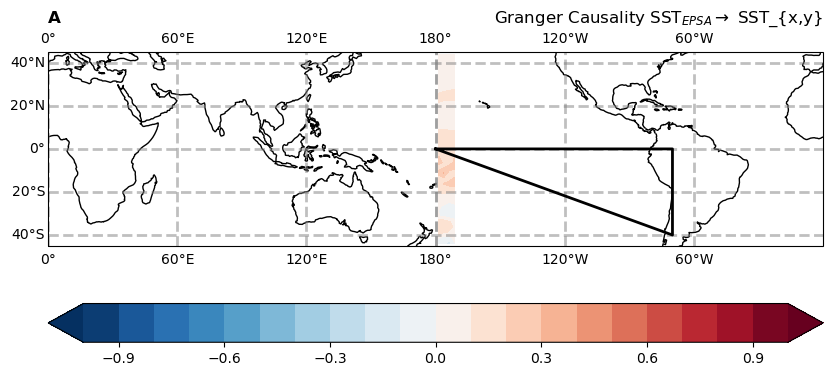

In [21]:
global_plot(Y1, Y1.lon, Y1.lat, "RdBu_r", levels=np.arange(-1., 1.1, .1), right_title=r"Granger Causality SST$_{EPSA} \rightarrow $ SST_{x,y}", left_title="A")

# Load and Prep SEB 

In [8]:
SEB_CMIP5 = xr.open_dataset("data/piControl/SEB_CMIP5_full.nc")
SEB_CMIP6 = xr.open_dataset("data/piControl/SEB_CMIP6_full.nc")
SEB_CMIP6

<xarray.Dataset>
Dimensions:    (model: 36, lat: 72, lon: 144, time: 120, bnds: 2)
Coordinates:
  * model      (model) object 'BCC-CSM2-MR' 'CESM2-WACCM' ... 'MRI-ESM2-0'
  * lat        (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float64 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 112 113 114 115 116 117 118 119
Dimensions without coordinates: bnds
Data variables: (12/19)
    NET        (model, time, lat, lon) float64 ...
    O          (model, time, lat, lon) float64 ...
    W          (model, time, lat, lon) float64 ...
    RH         (model, time, lat, lon) float64 ...
    DT         (model, time, lat, lon) float64 ...
    LH_Other   (model, time, lat, lon) float64 ...
    ...         ...
    LW_Other   (model, time, lat, lon) float64 ...
    SW_Other   (model, time, lat, lon) float64 ...
    EIS        (model, time, lat, lon) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    time_bnds  (time, bnds) float64 ...

In [11]:
LH_Tropics = SEB_CMIP6["LH_Other"].sel(model="CESM2").sel(lat=slice(-30, 30), lon=slice(-180, 180)).drop("model")
# LH_Tropics

In [15]:
LH_EPT = get_region("LH_Other", remove_land_full(SEB_CMIP6["LH_Other"], var="LH_Other")) #["EPT"]
SW_EPSA = get_region(name="SW", flux=SEB_CMIP6["SW"])["EPSA"].sel(model="CESM2").drop("model")
LH_EPT

{'WE': <xarray.DataArray 'LH_Other' (model: 36, time: 120)>
 array([[-0.09318678, -0.04717086, -0.08280873, ...,  0.08362062,
          0.09802147,  0.05713623],
        [ 0.33341722,  0.28995683,  0.21224354, ..., -0.14420429,
         -0.05790226,  0.11503102],
        [ 0.07432214,  0.02947383, -0.05762798, ...,  0.20702737,
          0.2510543 ,  0.20327106],
        ...,
        [ 0.05574661,  0.12912871,  0.18311066, ..., -0.09022194,
         -0.14872931, -0.07814041],
        [-0.01582943, -0.06066475, -0.13593822, ...,  0.20384327,
          0.1026918 ,  0.14204716],
        [ 0.08642276,  0.0237408 ,  0.03238746, ..., -0.01837271,
         -0.00645467,  0.05004284]])
 Coordinates:
   * model    (model) object 'BCC-CSM2-MR' 'CESM2-WACCM' ... 'MRI-ESM2-0'
   * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 112 113 114 115 116 117 118 119,
 'EPSA': <xarray.DataArray 'LH_Other' (model: 36, time: 120)>
 array([[-0.00591757, -0.00886061,  0.01612125, ..., -0.05597582,
         -0.0614

In [13]:
# Y1_EPSA, Y2_EPSA = sanity_check_sst(X=SW_EPSA, Y=LH_Tropics)

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


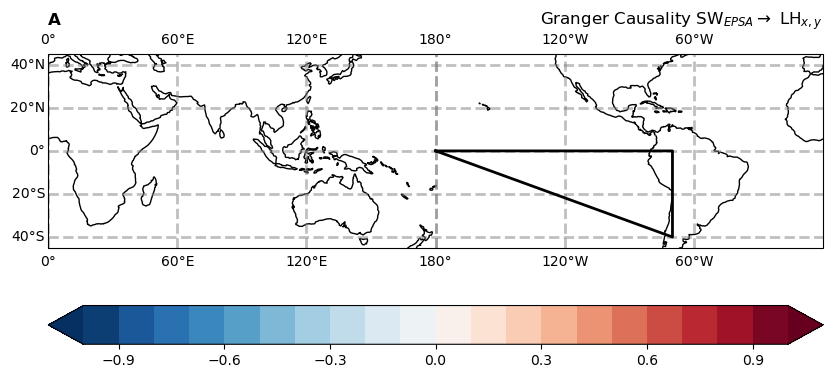

In [116]:
Y1_map = xr.DataArray(Y1_EPSA, dims=["lat", "lon"], coords={"lat": LH_Tropics.lat, "lon": LH_Tropics.lon})
global_plot(Y1_map, Y1_map.lon, Y1_map.lat, "RdBu_r", levels=np.arange(-1., 1.1, .1), right_title=r"Granger Causality SW$_{EPSA} \rightarrow $ LH$_{x,y}$", left_title="A")

# Run Granger Causality Analysis

In [70]:
for model in LH_EPT.model.values:
    print(model)
    mag = []
    try:
        # Remove NANS
        LH_EPT_model = LH_EPT.sel(model=model).dropna("time")
        SW_EPSA_model = SW_EPSA.sel(model=model, time=LH_EPT_model.time)
        # print(LH_EPT_model.shape, SW_EPSA_model.shape)
        # Run Granger Causality Pipeline
        causalityY1, causalityY2, magnitudeY1, magnitudeY2 = Granger_Pipeline(Y1=SW_EPSA_model, Y2=LH_EPT_model, verbose=False)
        mag.append(magnitudeY1)
        # print(causalityY1, causalityY2, magnitudeY1, magnitudeY2)
    except Exception as e:
        print(e)
        continue

BCC-CSM2-MR
CESM2-WACCM
GISS-E2-1-G
EC-Earth3-Veg
GISS-E2-2-H
E3SM-1-1
SAM0-UNICON
CESM2
MPI-ESM-1-2-HAM
CMCC-CM2-SR5
GFDL-ESM4
GISS-E2-1-H
E3SM-1-0
CESM2-FV2
INM-CM4-8
FGOALS-f3-L
CESM2-WACCM-FV2
EC-Earth3-Veg-LR
E3SM-2-0
MPI-ESM1-2-LR
CMCC-ESM2
CAS-ESM2-0
IITM-ESM
EC-Earth3
HadGEM3-GC31-MM
EC-Earth3-CC
GFDL-CM4
FIO-ESM-2-0
MIROC6
IPSL-CM6A-LR
NorESM1-F
MPI-ESM1-2-HR
INM-CM5-0
EC-Earth3-LR
HadGEM3-GC31-LL
MRI-ESM2-0


# Causality SO -> EPT

In [135]:
tos = xr.open_dataset("data/piControl/tos_anoms_mon_1850-2100_CMIP6_piControl.nc")
mag1, mag2 = [], []
for i, model in enumerate(tos.model.values):
    tos_regions = get_region(flux=tos["tos"].sel(model=model).drop("model"), name="tos")
    tos_EPT = tos_regions["EPSA"].resample(time="1Y").mean()
    tos_SO = tos_regions["SO"].resample(time="1Y").mean()

    try:
        # Run Granger Causality Pipeline
        causalityY1, causalityY2, magnitudeY1, magnitudeY2 = Granger_Pipeline(Y1=tos_SO, Y2=tos_EPT, include_zero_lag=False, verbose=False)
        mag1.append(magnitudeY1)
        mag2.append(magnitudeY2)
        print(model, magnitudeY1, magnitudeY2)
    except Exception as e:
        print(e)
        continue
    # if i == 5:
        # break

E3SM-1-1 nan 0.3230244628275545
E3SM-1-0 nan 0.29206012361065414
E3SM-1-1-ECA nan 0.289211976960373
KIOST-ESM -0.09906006836117201 0.3787808406348465
CIESM nan 0.3090410533751067
BCC-ESM1 nan 0.2503634063001698
BCC-CSM2-MR nan 0.4689416882968893
CESM2-WACCM nan -0.11888643380690495
CESM2-WACCM-FV2 0.35860990742614796 -0.4475052471419111
CESM2-FV2 -0.24130060158644695 -0.20524203276477498
CESM2 nan -0.056979865842145205
FGOALS-f3-L -0.31297614423041065 -0.03149880736978272
CAS-ESM2-0 -0.5316858391793232 0.32033999308234906
FGOALS-g3 -0.3583556782530838 0.0045316278551558176
SAM0-UNICON nan 0.44958948343189786
HadGEM3-GC31-LL nan 0.4738545875327598
HadGEM3-GC31-MM nan -0.019753712329284523
GFDL-ESM4 -0.26007009643967005 0.01361187921560253
GFDL-CM4 nan -0.003956253657790676
GISS-E2-2-H nan nan
GISS-E2-1-H nan nan
GISS-E2-2-G nan 0.23041499332139231
GISS-E2-1-G 0.17884758574204718 -0.08581758548323398
IITM-ESM nan nan
CanESM5 -0.060768135339610174 0.4756253367042164
CAMS-CSM1-0 -0.0669568

In [136]:
SO_to_EPT = xr.DataArray(mag1, dims="model", coords={"model": tos.model.values})
EPT_to_SO = xr.DataArray(mag2, dims="model", coords={"model": tos.model.values})
print(np.nanmean(SO_to_EPT))
print(np.nanmean(EPT_to_SO))

-0.1014825919628153
0.2074154406905733


In [137]:
swcf = xr.open_dataarray("data/piControl/swcf_east_sa_cmip6.nc")

In [138]:
SO_to_EPT = SO_to_EPT.sel(model=swcf.model)
EPT_to_SO = EPT_to_SO.sel(model=swcf.model)

LinregressResult(slope=3.1770652058067994, intercept=4.588085593482648, rvalue=0.23768422699676056, pvalue=0.3271632446410917, stderr=3.1490074371679087, intercept_stderr=0.793444953310326)


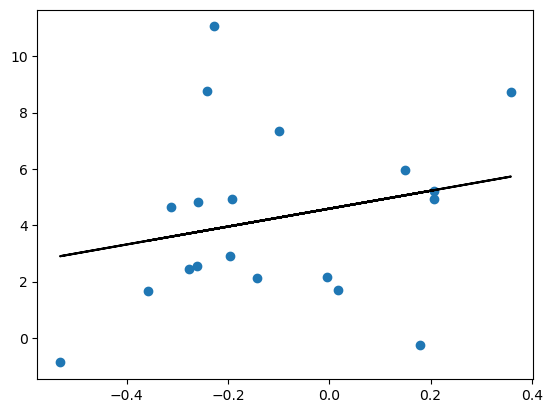

In [139]:
plt.scatter(SO_to_EPT[~np.isnan(SO_to_EPT)], swcf[~np.isnan(SO_to_EPT)])
reg = linregress(SO_to_EPT[~np.isnan(SO_to_EPT)], swcf[~np.isnan(SO_to_EPT)])
print(reg)
plt.plot(SO_to_EPT[~np.isnan(SO_to_EPT)], reg.slope*SO_to_EPT[~np.isnan(SO_to_EPT)] + reg.intercept, color="black")

LinregressResult(slope=-5.018512246066565, intercept=5.626955784667427, rvalue=-0.3853487349528019, pvalue=0.022251469648109458, stderr=2.091982401844526, intercept_stderr=0.7007962456101313)


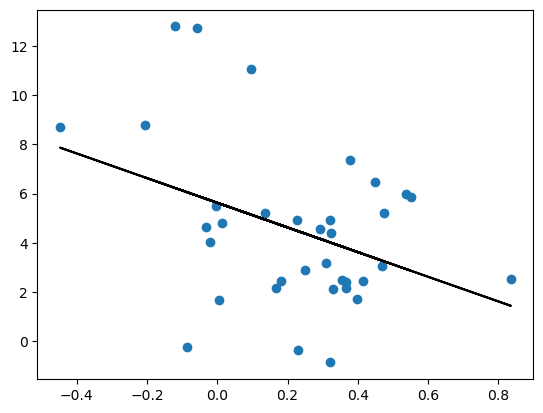

In [140]:
plt.scatter(EPT_to_SO[~np.isnan(EPT_to_SO)], swcf[~np.isnan(EPT_to_SO)])
reg = linregress(EPT_to_SO[~np.isnan(EPT_to_SO)], swcf[~np.isnan(EPT_to_SO)])
print(reg)
plt.plot(EPT_to_SO[~np.isnan(EPT_to_SO)], reg.slope*EPT_to_SO[~np.isnan(EPT_to_SO)] + reg.intercept, color="black")